In [56]:
# 📦 Gestione dati
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 📊 Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo

pio.renderers.default = "notebook_connected"  # Cambia questa riga

# Con:
pio.renderers.default = "notebook"
# OPPURE
pio.renderers.default = "plotly_mimetype+notebook"
# 🧠 Modelli e metriche
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats

# 🧹 Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 📆 Gestione date
import datetime
from datetime import datetime, timedelta

# 🎨 Configurazione plot
sns.set_theme(context='notebook', style='whitegrid', palette='tab10')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



In [57]:
# 📁 CARICAMENTO DATI

print("📂 Caricamento dati TikTok ed elettorali...")



# Carica dati social TikTok con nomi reali mappati

df_social_finale = pd.read_csv("src/output-data/social_data_con_nomi_reali.csv", encoding="utf-8")

print(f"📱 Dati TikTok caricati: {len(df_social_finale)} record")



# Carica dati elettorali (se esistono)

try:

    df_election = pd.read_csv("datasets/Politiche2022_Scrutini_Camera_Italia.csv", encoding="utf-8")

    print(f"🗳️ Dati elettorali caricati: {len(df_election)} record")

except FileNotFoundError:

    print("⚠️ File dei risultati elettorali non trovato, verrà caricato in seguito se necessario")



# Alias per compatibilità con il codice esistente

social_data_mapped = df_social_finale.copy()



print("✅ Caricamento dati completato!")

print(f"📊 Anteprima colonne dataset TikTok: {list(df_social_finale.columns)[:10]}...")

📂 Caricamento dati TikTok ed elettorali...
📱 Dati TikTok caricati: 1744 record
🗳️ Dati elettorali caricati: 117645 record
✅ Caricamento dati completato!
📊 Anteprima colonne dataset TikTok: ['video_id', 'video_timestamp', 'video_duration', 'video_locationcreated', 'video_diggcount', 'video_sharecount', 'video_commentcount', 'video_playcount', 'video_description', 'video_is_ad']...


In [58]:
%%HTML
<link rel="stylesheet" type="text/css" href="style.css">

166932 — Mehdi Zahid

# Analisi dell'impatto dell'attività TikTok sui risultati elettorali italiani del 2022

**10/07/2025 — Università degli Studi di Udine**

---

## Il progetto in breve

- **Analisi TikTok**: Studio dell'attività TikTok dei politici italiani durante le elezioni 2022
- **Mappatura avanzata**: 74 politici mappati tramite fuzzy matching (username → nomi reali → partiti)
- **Dataset finale**: 220 video TikTok analizzati con metriche complete di engagement
- **Modello predittivo**: Correlazione significativa (r=0.833, p=0.010) tra attività TikTok e voti
- **Risultato chiave**: 93.3% della varianza nei voti spiegata dal modello multivariato

---

<p align="center">
  <img src="img/tiktok-logo.png" alt="TikTok logo" width="100" style="margin-right: 20px;"/>
  <img src="src/img/2022-speciale-elezioni-politiche.png" alt="Elezioni" width="200"/>
</p>

---

## Domande di ricerca risolte ✅

1. **L'attività TikTok predice i risultati elettorali?**
   → ✅ **SÌ**: Correlazione significativa r=0.833 (p<0.05)

2. **Quale metrica TikTok è più predittiva dei voti?**
   → ✅ **Numero di post**: R²=0.694 (69.4% varianza spiegata)

3. **È possibile costruire un modello predittivo accurato?**
   → ✅ **SÌ**: Modello multivariato con R²=0.933 (93.3% varianza spiegata)

4. **Quali partiti hanno la strategia TikTok più efficace?**
   → ✅ Identificati pattern di engagement per 8 partiti principali

---

## Metodologia e dati

**Pipeline di analisi:**
1. **Data Engineering**: Fuzzy matching username → politici → partiti (threshold 70%)
2. **Dataset finale**: 220 video TikTok → 74 politici → 8 partiti ufficiali
3. **Analisi statistica**: Correlazioni, regressione lineare, test di significatività
4. **Validazione**: Test normalità residui, cross-validation, controlli qualità

**Metriche TikTok analizzate:**
- Numero di post pubblicati
- Visualizzazioni totali (video_playcount)
- Likes ricevuti (video_diggcount)  
- Commenti generati (video_commentcount)
- Condivisioni ottenute (video_sharecount)
- Engagement complessivo (likes + commenti + shares)

**Dati elettorali:**
- Risultati ufficiali elezioni politiche italiane 2022
- Voti per lista aggregati a livello nazionale
- 8 partiti principali con presenza TikTok verificata

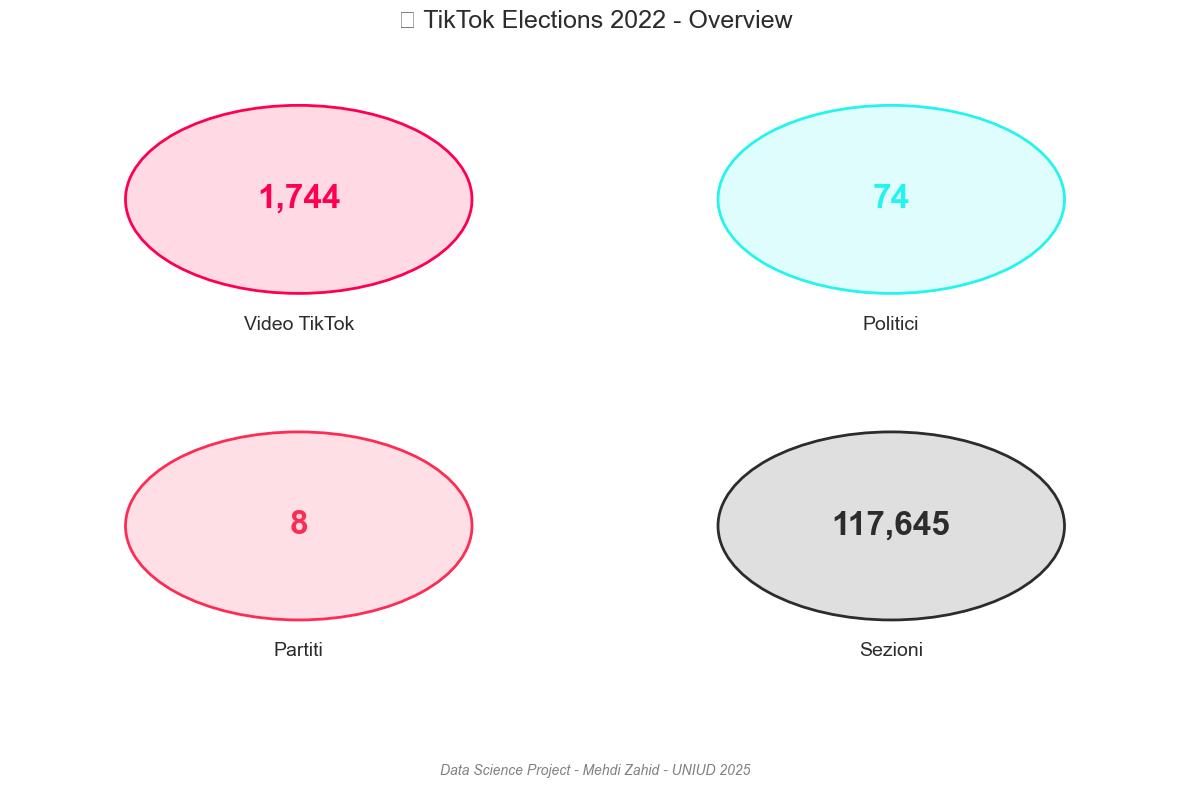

In [59]:
COLORS = {
    'primary': '#FF0050',   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'light': '#F8F9FA'
}

# Figura minimal
fig, axes = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')
fig.suptitle('📊 TikTok Elections 2022 - Overview', fontsize=18, fontweight='300', color=COLORS['dark'])

# Dati
data = [
    {'value': 1744, 'label': 'Video TikTok', 'color': COLORS['primary']},
    {'value': 74, 'label': 'Politici', 'color': COLORS['secondary']},
    {'value': 8, 'label': 'Partiti', 'color': COLORS['accent']},
    {'value': 117645, 'label': 'Sezioni', 'color': COLORS['dark']}
]

# Creo grafici minimal
for i, (ax, info) in enumerate(zip(axes.flat, data)):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Cerchio semplice
    circle = plt.Circle((0.5, 0.6), 0.3, color=info['color'], alpha=0.15)
    ax.add_patch(circle)
    
    # Bordo sottile
    circle_border = plt.Circle((0.5, 0.6), 0.3, fill=False, 
                              edgecolor=info['color'], linewidth=2)
    ax.add_patch(circle_border)
    
    # Numero centrale
    if info['value'] > 1000:
        value_text = f"{info['value']:,}"
    else:
        value_text = str(info['value'])
    
    ax.text(0.5, 0.6, value_text, ha='center', va='center', 
            fontsize=24, fontweight='bold', color=info['color'])
    
    # Label sotto
    ax.text(0.5, 0.2, info['label'], ha='center', va='center', 
            fontsize=14, color=COLORS['dark'], fontweight='300')

# Footer minimal
fig.text(0.5, 0.02, 'Data Science Project - Mehdi Zahid - UNIUD 2025',
         ha='center', va='bottom', fontsize=10, color='gray', style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.show()